# MPL for binary classification

In [46]:
import numpy as np
from numpy import argmax
import pandas as pd
import seaborn as sns

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve

In [48]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from IPython.display import Latex

In [49]:
import matplotlib.pyplot as plt
import sys

## Download data:

ttbar4top_unsorted.csv-file: https://drive.google.com/file/d/1aDbie_6K9UjCGeOUJU3HWtuUe7P_xUDz/view?usp=sharing

ttbar4top_sorted.csv-file: https://drive.google.com/file/d/1LVsZTvEgCq6GAtgyT1aQ1x_iSjAyexmj/view?usp=sharing

## The problem

Lets first see what this set actually looks like. Download the file, discuss the datastructure. 

Currently a hot topic at the Large Hadron Collider is the search for the production of 4 of the heaviest quarks (the top quark) in a single event. These special events are called "4-top events". A signal for the production of these events has not been observed so far. The discovery of "4-top events" is interesting since it might be that more events are measured than expected. This could point to physics beyond the Standard Model of particle physics, since new physical processes could also generate events with 4 top quarks. The top quarks decay to other particles which are then measured in the detector surrounding the point where the quarks were originally produced.


In [50]:
# Choose your path for ttbar4top_unsorted.csv
df2 = pd.read_csv("/Users/pmoskvit/NIKHEF_RU/DarkMatter/practice/MLworkshop/ttbar4top_unsorted.csv", header = None, sep='\n') # Put data in DataFrame
df2 = df2[0].str.split(';|,', expand=True) # Make split along ; and , delimiters
df2 = df2.fillna(0) # Replace None values with 0
n_obj = (len(df2.columns) - 5) // 5
df2 = df2.drop(range(5 + 5 * n_obj, len(df2.columns)), axis = 'columns') # Drop the empty column at the end

In [51]:
print(df2)

        0      1  2        3           4        5        6          7   \
0       21  ttbar  1  19.5924  -0.0410686  431.384  247.371   -1.15222   
1       21  ttbar  1  34.3615    -2.39277  104.553  50.5468    1.34776   
2       21  ttbar  1   24.356   -0.260029  255.675  73.0861    1.92294   
3       21  ttbar  1  36.5657   -0.666041  131.526  78.0257    1.10913   
4       21  ttbar  1  8.96628    -1.89928  185.195   79.061   -1.49199   
...     ..    ... ..      ...         ...      ...      ...        ...   
399995  21  ttbar  1  78.0656    -2.09791  505.124   154.12   -1.85327   
399996  21  ttbar  1  16.0266   -0.891785   79.986  79.5125  0.0465189   
399997  21  ttbar  1  73.1808      2.4646  194.662  81.8908   -1.50839   
399998  21  ttbar  1  8.83062    -2.63331  330.178  195.808   -1.11217   
399999  21  ttbar  1  20.8032     -2.6119  93.1788  81.5244   0.497099   

              8        9   ...       25       26         27         28  \
0        1.84686  213.946  ...  102.2

In [52]:
heads=['EventID', 'ProcessID', 'evtweight', 'MET', 'METphi']
for i in range (n_obj):
  heads.append('obj%d' % i)
  heads.append('obj%d_E' % i)
  heads.append('obj%d_pt' % i)
  heads.append('obj%d_eta' % i)
  heads.append('obj%d_phi' % i)
df2.columns = df2.columns[:0].tolist() + heads

In [53]:
df2.obj0

0         431.384
1         104.553
2         255.675
3         131.526
4         185.195
           ...   
399995    505.124
399996     79.986
399997    194.662
399998    330.178
399999    93.1788
Name: obj0, Length: 400000, dtype: object

In [54]:
print(df2)

       EventID ProcessID evtweight      MET      METphi     obj0   obj0_E  \
0           21     ttbar         1  19.5924  -0.0410686  431.384  247.371   
1           21     ttbar         1  34.3615    -2.39277  104.553  50.5468   
2           21     ttbar         1   24.356   -0.260029  255.675  73.0861   
3           21     ttbar         1  36.5657   -0.666041  131.526  78.0257   
4           21     ttbar         1  8.96628    -1.89928  185.195   79.061   
...        ...       ...       ...      ...         ...      ...      ...   
399995      21     ttbar         1  78.0656    -2.09791  505.124   154.12   
399996      21     ttbar         1  16.0266   -0.891785   79.986  79.5125   
399997      21     ttbar         1  73.1808      2.4646  194.662  81.8908   
399998      21     ttbar         1  8.83062    -2.63331  330.178  195.808   
399999      21     ttbar         1  20.8032     -2.6119  93.1788  81.5244   

          obj0_pt  obj0_eta obj0_phi  ...     obj4   obj4_E    obj4_pt  \
0

## The LHC dataset
The simulated training and validation data are provided in a one-line-per-event text format (CSV), where each line has variable length and contains 5 event-level quantities followed by low-level features for each object in the event. The format of CSV files are (in one line):

event ID; process ID; event weight; MET; METphi; obj1, E1, pt1, eta1, phi1; obj2, E2, pt2,
eta2, phi2; $\ldots$


<br>
$obj$ specifies the particles detected in the event (e.g. electron (e), photon (p), a so-called jet (j), a so-called b-jet (b) a muon (m) etc.). The + or - specifies the charge of the particle. 
<br>
$E,pt,eta,phi$ specify the 4-vector of the measured particle, i.e. the energy, transverse component of the momentum and the theta (given here in units of pseudorapidity) and phi angles.
<br>
'event ID' is a serial integer to uniquely identify that particular event in the run.
<br>
'event weight' is a real number to determine the likelihood of the process. This is a generator quantity and does not exist in real data. It should not be used for "training".
<br>
'process ID' is a string referring to the process which generated the event. In real life events this is unknown on a event-by-event basis, but in simulated data sets (like the one we are providing you with) this information \textit{is} accessible.
<br>
'MET and METphi' entries are the magnitude and the azimuthal angle of the missing transverse energy vector of the event, respectively. "Missing" means that this momentum is taken away by undetected particles, e.g. neutrinos.
<br>

As an example, an event corresponding to the final state of the 
background $t\bar{t}+2j$ process with two $b$-jets and one jet reads as follows:
<br>
$$
94;ttbar
;0.00167779;112288;1.74766;b,331927,147558,-1.44969,-1.76399;j,100406,85589,-0.568259,-1.17144;b,55808.8,54391.4,
-0.198215,1.726;j,72078.9,52432.5,-0.835736,1.57786;j,78649.8,40071.4,-1.28827,0.106601;
0.0133287; 57663.6; -2.81632; b,100054,-1.22689,0.177731;
;
$$

### Question 1: Discuss the data ? How many features do you expect ? Is this a problem?

### Question 2: How can we deal with this problem ? What was done in the dataset below ? Compare the first event between the two datasets.

In [55]:
# Choose your path for ttbar4top_sorted.csv
df = pd.read_csv("//Users/pmoskvit/NIKHEF_RU/DarkMatter/practice/MLworkshop/ttbar4top_sorted.csv", header = 0, sep=',') # Put data in DataFrame
df = df.fillna(0) # Replace None values with 0

Explain the format of the second csv file ....

### Question 3: Next we are normalizing the data. Why and how do we do this ?

In [56]:
def log_norm(data):
  return [np.log(elem) if elem!=0 else 0 for elem in data]

In [57]:
def z_norm(data):
  mean = data.mean()
  std = data.std()
  print("z_norm:mean=",mean)
  print("z_norm:std=",std)
  return [(x - mean) / std if x!=0 else 0 for x in data]

In [58]:
def minmax_norm(data, min, max):
  return [(elem-min)/(abs(min)+abs(max)) if elem!=0 else 0 for elem in data]

In [59]:
def make_norm(objname):
  df[objname + '_E'] = z_norm(df[objname + '_E'].astype(float))
  df[objname + '_pt'] = z_norm(df[objname + '_pt'].astype(float))
  df[objname + '_eta'] = minmax_norm(df[objname + '_eta'].astype(float), -6, 6) 
  df[objname + '_phi'] = minmax_norm(df[objname + '_phi'].astype(float), -3.1415, 3.1415)

In [60]:
print(df)

        EventID ProcessID  evtweight       MET    METphi  n_bjet  n_qjet  \
0            21     ttbar        1.0  19.59240 -0.041069       2       6   
1            21     ttbar        1.0  34.36150 -2.392770       2       0   
2            21     ttbar        1.0  24.35600 -0.260029       1       2   
3            21     ttbar        1.0  36.56570 -0.666041       3       2   
4            21     ttbar        1.0   8.96628 -1.899280       0       4   
...         ...       ...        ...       ...       ...     ...     ...   
399995       21     ttbar        1.0  78.06560 -2.097910       3       2   
399996       21     ttbar        1.0  16.02660 -0.891785       1       4   
399997       21     ttbar        1.0  73.18080  2.464600       0       3   
399998       21     ttbar        1.0   8.83062 -2.633310       1       6   
399999       21     ttbar        1.0  20.80320 -2.611900       1       5   

        n_muon  n_elec  n_lept  ...  lept3_charge  lept3_E  lept3_pt  \
0            0 

In [61]:
df.bjet1_E

0         431.3840
1         104.5530
2         304.6560
3         131.5260
4           0.0000
            ...   
399995     64.9411
399996     35.3333
399997      0.0000
399998     53.9184
399999     83.1383
Name: bjet1_E, Length: 400000, dtype: float64

In [62]:
make_norm('bjet1')
make_norm('bjet2')
make_norm('bjet3')
make_norm('bjet4')

z_norm:mean= 181.02023512500145
z_norm:std= 188.83333889873455
z_norm:mean= 98.73634724499615
z_norm:std= 93.9492357092093
z_norm:mean= 65.86293100974976
z_norm:std= 111.93283394203361
z_norm:mean= 34.89046987250051
z_norm:std= 53.059609574742005
z_norm:mean= 15.769713768249895
z_norm:std= 54.90648979548355
z_norm:mean= 8.10125112924995
z_norm:std= 24.736292002315157
z_norm:mean= 3.7153110610000097
z_norm:std= 25.065000857258024
z_norm:mean= 1.8386103337500117
z_norm:std= 10.645455148789072


In [63]:
df.bjet1_E

0         1.325845
1        -0.404946
2         0.654735
3        -0.262105
4         0.000000
            ...   
399995   -0.614717
399996   -0.771511
399997    0.000000
399998   -0.673090
399999   -0.518351
Name: bjet1_E, Length: 400000, dtype: float64

In [64]:
make_norm('qjet1')
make_norm('qjet2')
make_norm('qjet3')
make_norm('qjet4')

z_norm:mean= 286.856947764747
z_norm:std= 276.8745307011714
z_norm:mean= 137.31218700349802
z_norm:std= 112.49036356402678
z_norm:mean= 184.13980365475453
z_norm:std= 207.65215364891415
z_norm:mean= 81.18633445550063
z_norm:std= 69.57675172457007
z_norm:mean= 122.17040180125089
z_norm:std= 171.17085353766012
z_norm:mean= 48.66640348250047
z_norm:std= 42.16010699977445
z_norm:mean= 81.41873953424991
z_norm:std= 149.84496744626418
z_norm:mean= 29.346332232499677
z_norm:std= 31.47516001395322


In [65]:
make_norm('lept1')
make_norm('lept2')
make_norm('lept3')
make_norm('lept4')

z_norm:mean= 31.66788463574989
z_norm:std= 76.31834574159215
z_norm:mean= 17.893014265000083
z_norm:std= 39.08081987328764
z_norm:mean= 2.880435028250023
z_norm:std= 22.792904004929227
z_norm:mean= 1.6099254687499955
z_norm:std= 11.705526663968373
z_norm:mean= 0.14136695675000013
z_norm:std= 5.161657919123923
z_norm:mean= 0.07914291724999996
z_norm:std= 2.7099674064369625
z_norm:mean= 0.003961356750000001
z_norm:std= 0.7075060571853612
z_norm:mean= 0.0022991897500000006
z_norm:std= 0.35276755458316766


### Question 3: Can you explain why we do the following conversion ?

In [66]:
df['lept1_charge'] = df['lept1_charge'].astype(int)
df['lept2_charge'] = df['lept2_charge'].astype(int)
df['lept3_charge'] = df['lept3_charge'].astype(int)
df['lept4_charge'] = df['lept4_charge'].astype(int)

### Question 4: What is the following command showing us ?

In [67]:
df.head(5)

,EventID,ProcessID,evtweight,MET,METphi,n_bjet,n_qjet,n_muon,n_elec,n_lept,...,lept3_charge,lept3_E,lept3_pt,lept3_eta,lept3_phi,lept4_charge,lept4_E,lept4_pt,lept4_eta,lept4_phi
0,21,ttbar,1.0,19.59240,-0.041069,2,6,0,0,0,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,21,ttbar,1.0,34.36150,-2.392770,2,0,0,1,1,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,21,ttbar,1.0,24.35600,-0.260029,1,2,1,0,1,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,21,ttbar,1.0,36.56570,-0.666041,3,2,0,0,0,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,21,ttbar,1.0,8.96628,-1.899280,0,4,0,0,0,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [68]:
df.qjet1_E

0        -0.263336
1         0.000000
2        -0.112621
3         0.703539
4        -0.367177
            ...   
399995    0.788325
399996   -0.747165
399997   -0.332985
399998    0.156465
399999   -0.699516
Name: qjet1_E, Length: 400000, dtype: float64

In [69]:
n_obj = 2 # you can play with the number of objects (maximally 12 )
endofstring=10+n_obj*4

### Question 5: What is the following command doing ? Why do we need this ?

In [70]:
process_mapping = {
           'ttbar': 0,
            '4top': 1}
df['ProcessID'] = df['ProcessID'].map(process_mapping)

In [71]:
variables = df.columns[3:endofstring].tolist()
print(variables)

['MET', 'METphi', 'n_bjet', 'n_qjet', 'n_muon', 'n_elec', 'n_lept', 'bjet1_E', 'bjet1_pt', 'bjet1_eta', 'bjet1_phi', 'bjet2_E', 'bjet2_pt', 'bjet2_eta', 'bjet2_phi']


In [72]:
x = df[variables].to_numpy()
y = pd.get_dummies(df['ProcessID']).to_numpy()

### Question 6: Can you explain what we are doing next ? Why do we do this ? What is happening if we reduce the train_size to 0.1 ?

In [73]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9)

### Question 7: Next things happen... What is a sequational model ? Explain the activation function ? What is dropout doing (we should change both in the following) ?

In [74]:
model = Sequential()
model.add(Dense(64, input_dim=len(variables), activation='softmax'))
#model.add(Dropout(0.01))
model.add(Dense(22, activation='softmax'))
#model.add(Dense(24, activation='softmax'))
#model.add(Dropout(0.01))
model.add(Dense(2, activation='softmax'))

### Question 8: Now we compile our ML model. We use a loss, optimizer and a metric. Can you explain them ? Propose a change.

In [75]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                1024      
_________________________________________________________________
dense_4 (Dense)              (None, 22)                1430      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 46        
Total params: 2,500
Trainable params: 2,500
Non-trainable params: 0
_________________________________________________________________


### Question 9: Why do we have so many trainable parameters ? Can you draw (or explain) the network structure ?

In [76]:
history = model.fit(x_train, y_train, validation_split=0.1,
          batch_size=128, verbose=1,
          epochs=10)

Train on 324000 samples, validate on 36000 samples
Epoch 1/10
324000/324000 [==============================] - 3s 10us/sample - loss: 0.5079 - accuracy: 0.8004 - val_loss: 0.5026 - val_accuracy: 0.7984
Epoch 2/10
324000/324000 [==============================] - 3s 8us/sample - loss: 0.4998 - accuracy: 0.8004 - val_loss: 0.5028 - val_accuracy: 0.7984
Epoch 3/10
324000/324000 [==============================] - 3s 8us/sample - loss: 0.4998 - accuracy: 0.8004 - val_loss: 0.5029 - val_accuracy: 0.7984
Epoch 4/10
324000/324000 [==============================] - 3s 9us/sample - loss: 0.4998 - accuracy: 0.8004 - val_loss: 0.5026 - val_accuracy: 0.7984
Epoch 5/10
324000/324000 [==============================] - 3s 8us/sample - loss: 0.4998 - accuracy: 0.8004 - val_loss: 0.5027 - val_accuracy: 0.7984
Epoch 6/10
324000/324000 [==============================] - 3s 8us/sample - loss: 0.4999 - accuracy: 0.8004 - val_loss: 0.5026 - val_accuracy: 0.7984
Epoch 7/10
324000/324000 [======================

In [77]:
print(history.history)

{'loss': [0.5078530914165356, 0.49982850661101164, 0.49983542750794213, 0.4998432094314952, 0.49983506481147105, 0.49985314403345554, 0.4998414604516677, 0.4998413519329495, 0.49983646007526067, 0.4998351530616666], 'accuracy': [0.8004352, 0.8004352, 0.8004352, 0.8004352, 0.8004352, 0.8004352, 0.8004352, 0.8004352, 0.8004352, 0.8004352], 'val_loss': [0.5026389206250509, 0.5027541247473822, 0.5028965357144674, 0.5026420421600342, 0.5027309234407213, 0.5026322489844428, 0.5027563399208916, 0.5026442914538913, 0.5026402490403917, 0.5026313446362813], 'val_accuracy': [0.7983889, 0.7983889, 0.7983889, 0.7983889, 0.7983889, 0.7983889, 0.7983889, 0.7983889, 0.7983889, 0.7983889]}


## Question: Let us now plot the training & validation accuracy values. Why are they different ?

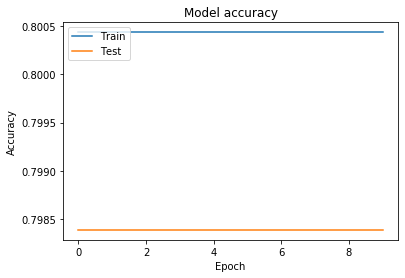

In [78]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

## Question: The true accuracy is not 0.8, but 0.5. For an accuracy of 0.8 this network does not learn anything, but "all events are background". Can you explain why ? The true accuracy (for a balanced dataset) is 0.5/0.8 * the accuracy written here.

Plot training & validation loss values

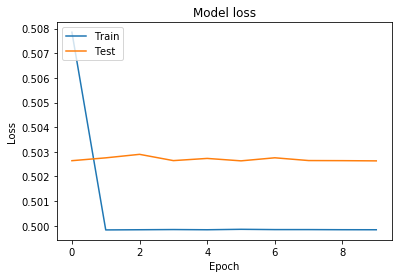

In [79]:
plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [80]:
y_pred = model.predict(x_test)[:, 1]
y_binary = 1.0*(y_pred > 0.5)
classes = y_test[:, 1]
print(confusion_matrix(y_test[:, 1], y_binary, labels=[0, 1]))

[[31917     0]
 [ 8083     0]]


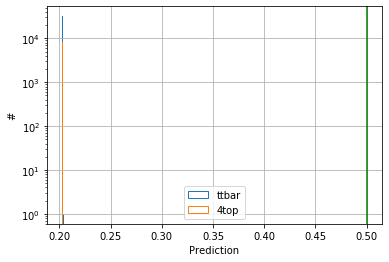

In [81]:
plt.figure(3)
plt.hist(y_pred[classes == 0], 100, histtype="step", label="ttbar")
plt.hist(y_pred[classes == 1], 100, histtype="step", label="4top")
plt.axvline(0.5,color='g')
plt.xlabel("Prediction")
plt.ylabel("#")
plt.grid()
plt.yscale("log")
plt.legend()

In [82]:
x_truly_ttbar = x_test[y_test[:, 1] == 0]
y_binary_ttbar = y_binary[y_test[:, 1] == 0] 
x_ttbar_right = x_truly_ttbar[y_binary_ttbar == 0]
x_ttbar_wrong = x_truly_ttbar[y_binary_ttbar == 1]

In [83]:
x_truly_4top = x_test[y_test[:, 1] == 1]
y_binary_4top = y_binary[y_test[:, 1] == 1] 
x_4top_right = x_truly_4top[y_binary_4top == 1]
x_4top_wrong = x_truly_4top[y_binary_4top == 0]

In [84]:
def count_objects(events, objid=""):
  n_objects = np.zeros(len(events))
  for i, v in enumerate(variables):
    if v in objid:
      n_objects += events[:, i]
  return n_objects

In [85]:
count_objid = "n_bjet,n_qjet,n_lept"

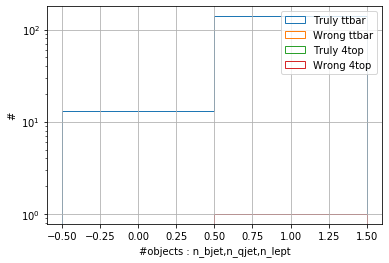

In [86]:
plt.figure(4)
bins = np.arange(-0.5, n_obj+0.5, 1)
plt.hist(count_objects(x_ttbar_right, count_objid), bins, histtype="step", label="Truly ttbar")
plt.hist(count_objects(x_ttbar_wrong, count_objid), bins, histtype="step", label="Wrong ttbar")
plt.hist(count_objects(x_4top_right, count_objid), bins, histtype="step", label="Truly 4top")
plt.hist(count_objects(x_4top_wrong, count_objid), bins, histtype="step", label="Wrong 4top")
plt.xlabel("#objects : " + count_objid)
plt.ylabel("#")
plt.grid()
plt.yscale("log")
plt.legend()

(0, 1)

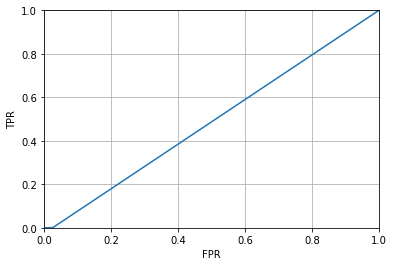

In [87]:
fpr, tpr, _ = roc_curve(y_test[:, 1], y_pred)
plt.figure(5)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])